In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
fangraphs = pd.read_csv('./fangraphs_season_level.csv')
savant = pd.read_csv('./savant_pitch_level.csv')

savant.loc[savant['balls'] == 4, 'balls'] = 3
savant.loc[savant['strikes'] == 3, 'strikes'] = 2

In [4]:
savant.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,hit_location,balls,strikes,game_year,...,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced
count,2135260.00,2135075.00,2135075.00,2136337.00,2136337.00,2135285.00,477478.00,2136337.00,2136337.00,2136337.00,...,2136337.00,2136337.00,2126707.00,2136337.00,2136199.00,2136337.00,2136337.00,2136337.00,2136337.00,2136337.00
mean,88.91,-0.79,5.81,615015.87,612938.96,9.08,5.09,0.88,0.90,2022.00,...,2.26,2.27,175.59,0.00,0.00,0.57,0.43,31.21,8.32,1.47
std,6.10,1.85,0.55,61021.46,62150.60,4.23,2.63,0.97,0.83,0.82,...,2.56,2.64,72.04,0.03,0.24,0.49,0.49,26.64,6.90,0.70
min,30.10,-5.34,0.76,405395.00,405395.00,1.00,1.00,0.00,0.00,2021.00,...,0.00,0.00,0.00,-0.78,-1.54,0.00,0.00,1.00,1.00,1.00
25%,84.60,-2.10,5.54,592206.00,592662.00,5.00,2.00,0.00,0.00,2021.00,...,0.00,0.00,132.00,0.00,-0.07,0.00,0.00,9.00,3.00,1.00
50%,89.80,-1.49,5.85,641154.00,623352.00,11.00,5.00,1.00,1.00,2022.00,...,1.00,1.00,199.00,0.00,-0.02,1.00,0.00,22.00,6.00,1.00
75%,93.80,0.98,6.15,664702.00,663752.00,13.00,8.00,2.00,2.00,2023.00,...,3.00,4.00,222.00,0.00,0.04,1.00,1.00,50.00,13.00,2.00
max,104.80,4.75,8.11,807799.00,701643.00,14.00,9.00,4.00,3.00,2023.00,...,28.00,28.00,360.00,0.91,3.65,1.00,1.00,131.00,35.00,5.00


In [5]:
savant.pitch_name.value_counts() / len(savant) * 100

pitch_name
4-Seam Fastball   33.58
Slider            17.67
Sinker            15.41
Changeup          11.14
Curveball          7.52
Cutter             7.34
Sweeper            2.87
Knuckle Curve      2.01
Split-Finger       1.78
Slurve             0.35
Other              0.15
Eephus             0.05
Forkball           0.04
Slow Curve         0.01
Knuckleball        0.01
Pitch Out          0.01
Screwball          0.00
Name: count, dtype: float64

In [28]:
savant.description.unique()
# swinging_strike, foul_tip, swinging_strike_blocked, bunt_foul_tip, missed_bunt

array(['swinging_strike', 'foul', 'ball', 'hit_into_play', 'blocked_ball',
       'called_strike', 'foul_tip', 'hit_by_pitch', 'foul_bunt',
       'swinging_strike_blocked', 'missed_bunt', 'pitchout',
       'bunt_foul_tip', 'foul_pitchout', 'unknown_strike'], dtype=object)

In [38]:
fangraphs.columns

Index(['PlayerId', 'MLBAMID', 'Name', 'NameASCII', 'Throws', 'Season', 'Age',
       'Team', 'Role', 'G',
       ...
       'Pit_plus_FC', 'Stf_plus_FS', 'Loc_plus_FS', 'Pit_plus_FS',
       'Stf_plus_FO', 'Loc_plus_FO', 'Pit_plus_FO', 'Stuff_plus',
       'Location_plus', 'Pitching_plus'],
      dtype='object', length=308)

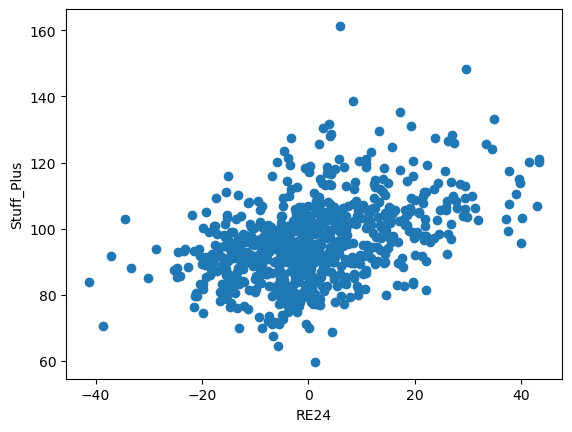

array([[1.        , 0.55568429],
       [0.55568429, 1.        ]])

In [166]:
reliever = fangraphs[(fangraphs['Role']=='SP') & (fangraphs['IP'] > 15)]
plt.scatter(reliever['RE24'], reliever['Stuff_plus'])
plt.xlabel('RE24')
plt.ylabel('Stuff_Plus')
plt.show()

np.corrcoef(reliever['SwStr_pct'], reliever['Stuff_plus'])

In [27]:
savant.groupby(['game_year', 'role_key']).pitch_number_appearance.sum()


game_year  role_key
2021       RP           3930778
           SP          17674120
2022       RP           3754634
           SP          18465683
2023       RP           4202254
           SP          18656212
Name: pitch_number_appearance, dtype: int64

In [39]:
data = savant.loc[(savant['role_key'] == 'SP') & (savant['pitch_type'] == 'FF'), ['delta_run_exp', 'release_spin_rate']].reset_index(drop=True)




In [40]:
data.rename(columns={'delta_run_exp':'run_exp', 'release_spin_rate':'spin_rate'}, inplace=True)

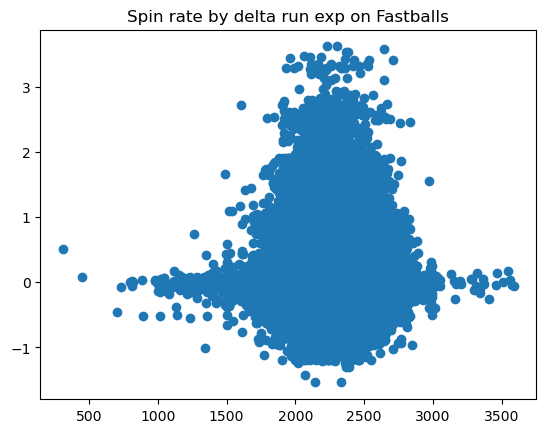

In [41]:
plt.scatter(data['spin_rate'], data['run_exp'])
plt.title('Spin rate by delta run exp on Fastballs')
plt.show()

In [42]:
savant['pitch_type'].unique()

array(['FF', 'SL', 'CU', 'SI', 'CH', 'FS', 'KC', 'FC', 'SV', 'ST', 'FA',
       'CS', 'PO', 'EP', nan, 'SC', 'KN', 'FO'], dtype=object)

In [9]:
matrix = [[0, 0, 0, 0, .461], [1, 0, 0, 0, .831], [0, 1, 0, 0, 1.068], [1, 1, 0, 0, 1.373], [0, 0, 1, 0, 1.426], [1, 0, 1, 0, 1.798], [0, 1, 1, 0, 1.92], [1, 1, 1, 0, 2.282],
          [0, 0, 0, 1, .243], [1, 0, 0, 1, .489], [0, 1, 0, 1, .644], [1, 1, 0, 1, .908], [0, 0, 1, 1, .865], [1, 0, 1, 1, 1.14], [0, 1, 1, 1, 1.352], [1, 1, 1, 1, 1.52],
          [0, 0, 0, 2, .095], [1, 0, 0, 2, .214], [0, 1, 0, 2, .305], [1, 1, 0, 2, .343], [0, 0, 1, 2, .413], [1, 0, 1, 2, .471], [0, 1, 1, 2, .570], [1, 1, 1, 2, .736]
         ]

run_exp = pd.DataFrame(matrix, columns=['on_1b', 'on_2b', 'on_3b', 'outs', 'run_exp'])

data = savant.sort_values(by=['game_date','pitcher', 'pitch_number_appearance'])

data[['on_1b', 'on_2b', 'on_3b']] = data[['on_1b', 'on_2b', 'on_3b']].applymap(lambda x: 1 if pd.notnull(x) else 0)
data = data.rename(columns={'outs_when_up': 'outs'})

data['runs'] = (data['post_home_score'] - data['home_score']) + (data['post_away_score'] - data['away_score'])

# Merge Run expected values
data = pd.merge(data, run_exp, how='left', on=['on_1b', 'on_2b', 'on_3b', 'outs'])

data['run_exp_chg'] = np.where(data['pitch_number_appearance'] == 1, 0.00, round(-data['run_exp'].diff(1), 3).fillna(-.098))

data['run_exp_end'] = data['run_exp'] + data['run_exp_chg']
data['events'].replace(['field_out', 'strikeout',
       'grounded_into_double_play','fielders_choice_out','double_play', 'caught_stealing_2b', 'caught_stealing_3b',
        'strikeout_double_play', 'other_out',
       'pickoff_2b', 'pickoff_caught_stealing_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b', 'sac_bunt_double_play','caught_stealing_home', 'pickoff_3b',
       'pickoff_caught_stealing_home'], 'field_out', inplace=True)

data['outs_end_inn'] = [1 if x=='field_out' and y ==2 else 0 for (x,y) in zip(data['events'], data['outs'])]

# Resets the ending run expected value
data['run_exp_end'] = [0 if x==1 else y for (x,y) in zip(data['outs_end_inn'], data['run_exp_end'])]

data['run_exp_chg'] = [-y if x == 1 else z for (x,y,z) in zip(data['outs_end_inn'], data['run_exp'], data['run_exp_chg'])]


data['run_exp_chg'].replace([-0.000], 0.000, inplace=True)

data['re24'] = data['run_exp_chg'] + data['runs']

In [10]:
wra_matrix = [
    [0, 0, 0.314, 1, 0, -0.034],
    [0, 0, 0.314, 0, 1, 0.028],
    [0, 1, 0.265, 1, 0, -0.047],
    [0, 1, 0.265, 0, 1, 0.024],
    [0, 2, 0.197, 1, 0, -0.135],
    [0, 2, 0.197, 0, 1, 0.017],
    [1, 0, 0.356, 1, 0, -0.038],
    [1, 0, 0.356, 0, 1, 0.048],
    [1, 1, 0.300, 1, 0, -0.053],
    [1, 1, 0.300, 0, 1, 0.039],
    [1, 2, 0.222, 1, 0, -0.152],
    [1, 2, 0.222, 0, 1, 0.032],
    [2, 0, 0.426, 1, 0, -0.047],
    [2, 0, 0.426, 0, 1, 0.078],
    [2, 1, 0.357, 1, 0, -0.06],
    [2, 1, 0.357, 0, 1, 0.082],
    [2, 2, 0.269, 1, 0, -0.184],
    [2, 2, 0.269, 0, 1, 0.075],
    [3, 0, 0.540, 1, 0, -0.043],
    [3, 0, 0.540, 0, 1, 0.104],
    [3, 1, 0.477, 1, 0, -0.067],
    [3, 1, 0.477, 0, 1, 0.147],
    [3, 2, 0.379, 1, 0, -0.05],
    [3, 2, 0.379, 0, 1, 0.214]
]


wra = pd.DataFrame(wra_matrix, columns=['balls', 'strikes', 'woba', 'is_strike', 'is_ball', 'wraa_change'])


In [11]:
data['is_ball'] = [1 if x == 'B' else 0 for x in data['type']]
data['is_strike'] = [1 if x != 'B' else 0 for x in data['type']]

data = pd.merge(data, wra, how='left', on=['balls', 'strikes', 'is_ball', 'is_strike'])

data['rv'] = data['re24']

data['rv'] = [y if x == 0 else x for (x,y) in zip(data['rv'], data['wraa_change'])]
data['rv'] = [x if not pd.isna(x) else -0.098 for x in data['rv']]

data['rv/100'] = data['rv'] / data.groupby(['player_name', 'pitch_name', 'game_year'])['pitch_number_appearance'].transform('sum') * 100





In [12]:
# Qualified SP = 162 Innings

fangraphs['Inn_per_appear'] = fangraphs.apply(lambda row: math.ceil(row['IP'] / row['G']) if row['G'] != 0 else 0, axis=1)

fangraphs[fangraphs['Role'] == 'SP']




,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Stf_plus_FS,Loc_plus_FS,Pit_plus_FS,Stf_plus_FO,Loc_plus_FO,Pit_plus_FO,Stuff_plus,Location_plus,Pitching_plus,Inn_per_appear
2179,1157,488984,Tommy Hunter,Tommy Hunter,R,2021,34,NYM,SP,1,...,NaN,NaN,NaN,NaN,NaN,NaN,96.165,114.753,107.765,2
2180,1943,425844,Zack Greinke,Zack Greinke,R,2021,37,HOU,SP,29,...,NaN,NaN,NaN,NaN,NaN,NaN,92.100,102.272,98.103,6
2181,2233,425794,Adam Wainwright,Adam Wainwright,R,2021,39,STL,SP,32,...,NaN,NaN,NaN,NaN,NaN,NaN,108.526,103.572,102.683,7
2182,2429,446372,Corey Kluber,Corey Kluber,R,2021,35,NYY,SP,16,...,NaN,NaN,NaN,NaN,NaN,NaN,106.694,99.885,101.342,5
2183,2520,458681,Lance Lynn,Lance Lynn,R,2021,34,CHW,SP,28,...,NaN,NaN,NaN,NaN,NaN,NaN,103.711,103.259,102.418,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,27758,690986,Kyle Harrison,Kyle Harrison,L,2023,21,SFG,SP,7,...,NaN,NaN,NaN,NaN,NaN,NaN,95.130,99.157,97.886,5
3321,29832,680232,Jackson Wolf,Jackson Wolf,L,2023,24,SDP,SP,1,...,NaN,NaN,NaN,NaN,NaN,NaN,116.755,97.617,98.347,5
3322,29911,671096,Andrew Abbott,Andrew Abbott,L,2023,24,CIN,SP,21,...,NaN,NaN,NaN,NaN,NaN,NaN,86.593,100.785,96.962,6
3323,29928,689266,Dylan Dodd,Dylan Dodd,L,2023,25,ATL,SP,7,...,NaN,NaN,NaN,NaN,NaN,NaN,81.532,106.065,97.501,5


In [ ]:
data[(data['game_year'] == 2023) & (data['player_name'] == 'Ohtani, Shohei')].groupby(['player_name', 'pitch_name', 'game_year']).agg({'rv' : 'sum', 'rv/100' : 'sum'}).sort_values(by='rv').head(50)

#################################
###### Innings pitched per appearance for qualified pitchers
#################################




In [36]:
players_wanted = fangraphs[(fangraphs['Role'] == 'SP')]
#  & (fangraphs['Inn_per_appear'] >= 5.)
players_wanted = players_wanted['MLBAMID'].unique()
len(players_wanted)

645

In [35]:
sp = data[(data['pitcher'].isin(players_wanted)) & (data['role_key'] == 'SP')].reset_index(drop=True)
sp

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,run_exp_chg,run_exp_end,outs_end_inn,re24,is_ball,is_strike,woba,wraa_change,rv,rv/100
0,FF,2021-04-01,87.400,-2.160,6.330,"Greinke, Zack",592192,425844,NaN,foul,...,0.000,0.461,0,0.000,0,1,0.314,-0.034,-0.034,-0.000
1,FF,2021-04-01,88.500,-2.220,6.310,"Greinke, Zack",592192,425844,NaN,called_strike,...,0.000,0.461,0,0.000,0,1,0.265,-0.047,-0.047,-0.000
2,SL,2021-04-01,81.700,-2.060,6.450,"Greinke, Zack",592192,425844,NaN,ball,...,0.000,0.461,0,0.000,1,0,0.197,0.017,0.017,0.000
3,CH,2021-04-01,88.400,-2.190,6.190,"Greinke, Zack",592192,425844,field_out,hit_into_play,...,0.000,0.461,0,0.000,0,1,0.222,-0.152,-0.152,-0.001
4,FF,2021-04-01,88.800,-2.250,6.320,"Greinke, Zack",657656,425844,NaN,called_strike,...,0.218,0.461,0,0.218,0,1,0.314,-0.034,0.218,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228027,FF,2023-10-01,93.400,2.270,4.560,"Harrison, Kyle",605141,690986,field_out,hit_into_play,...,0.000,0.489,0,0.000,0,1,0.379,-0.050,-0.050,-0.000
1228028,SV,2023-10-01,83.100,2.260,4.630,"Harrison, Kyle",518692,690986,NaN,ball,...,0.275,0.489,0,0.275,1,0,0.314,0.028,0.275,0.004
1228029,SL,2023-10-01,87.200,2.330,4.620,"Harrison, Kyle",518692,690986,NaN,called_strike,...,0.000,0.214,0,0.000,0,1,0.356,-0.038,-0.038,-0.006
1228030,SV,2023-10-01,82.900,2.250,4.600,"Harrison, Kyle",518692,690986,NaN,ball,...,0.000,0.214,0,0.000,1,0,0.300,0.039,0.039,0.001


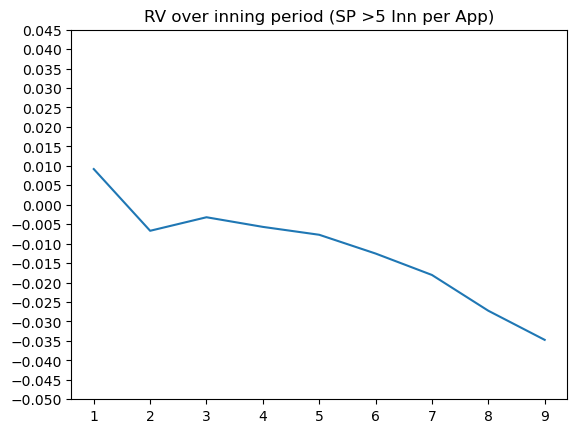

In [15]:
# Lets plot the average rv/100 per IP line chart
test = sp
plt.plot(test['inning'].unique(), test.groupby('inning').agg({'rv' : 'mean'}))
plt.yticks(np.arange(-0.05, 0.05, 0.005))
plt.title('RV over inning period (SP >5 Inn per App)')
plt.show()

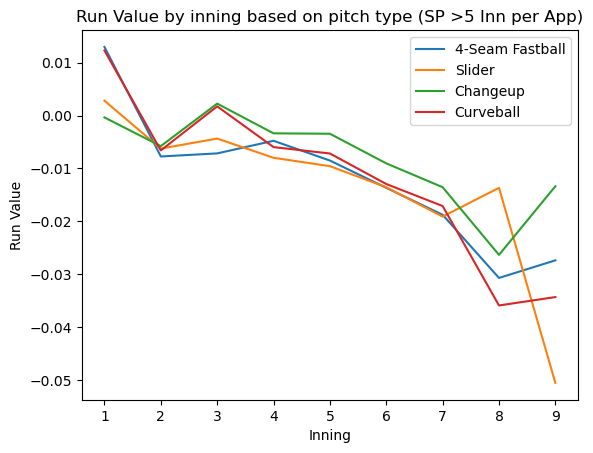

In [16]:
# At bat number vs. Run value on a particular pitch
cool = sp[sp['pitch_name'].isin(['4-Seam Fastball', 'Slider', 'Changeup', 'Curveball'])]
pitch_types = cool['pitch_name'].unique()

colors = plt.cm.tab10(np.arange(len(pitch_types)))

for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('inning')['rv'].mean()
    plt.plot(s.index, s, label=pitch_type, color=color)

plt.title('Run Value by inning based on pitch type (SP >5 Inn per App)')
plt.xlabel('Inning')
plt.ylabel('Run Value')
plt.legend()
plt.show()

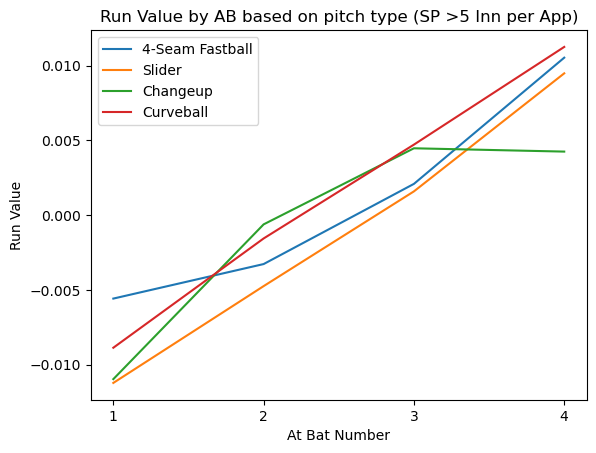

In [17]:
# At bat number vs. Run value on a particular pitch
cool = sp[sp['pitch_name'].isin(['4-Seam Fastball', 'Slider', 'Changeup', 'Curveball']) & (sp['times_faced'] < 5)]
pitch_types = cool['pitch_name'].unique()

colors = plt.cm.tab10(np.arange(len(pitch_types)))

for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('times_faced')['rv'].mean()
    plt.plot(s.index, s, label=pitch_type, color=color)

plt.title('Run Value by AB based on pitch type (SP >5 Inn per App)')
plt.xlabel('At Bat Number')
plt.ylabel('Run Value')
plt.xticks(range(1,5))
plt.legend()
plt.show()

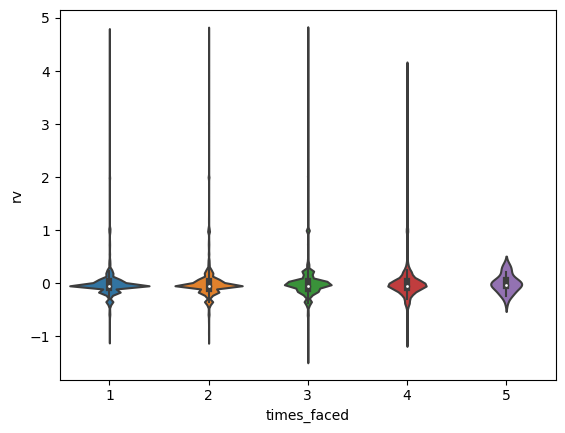

In [18]:
# Violin plot
sup = sp
sns.violinplot(x='times_faced', y='rv', data=sup)
plt.show()

In [19]:
sp.groupby('pitch_name')['pitch_name'].count().sort_values(ascending=False)

pitch_name
4-Seam Fastball    412570
Slider             191388
Sinker             180077
Changeup           154054
Curveball          107300
Cutter              94951
Knuckle Curve       29929
Sweeper             26239
Split-Finger        22764
Slurve               7136
Forkball              664
Slow Curve            150
Knuckleball           144
Pitch Out              53
Other                  11
Eephus                  2
Screwball               1
Name: pitch_name, dtype: int64

In [20]:
sp.pitch_name.unique()

array(['4-Seam Fastball', 'Slider', 'Changeup', 'Curveball', 'Sinker',
       'Cutter', 'Sweeper', 'Knuckle Curve', 'Split-Finger', 'Slow Curve',
       'Slurve', 'Screwball', 'Other', 'Eephus', 'Pitch Out', nan,
       'Forkball', 'Knuckleball'], dtype=object)

In [21]:
sp['good_pitch'] = [1 if x < 0 else 0 for x in sp['rv']]


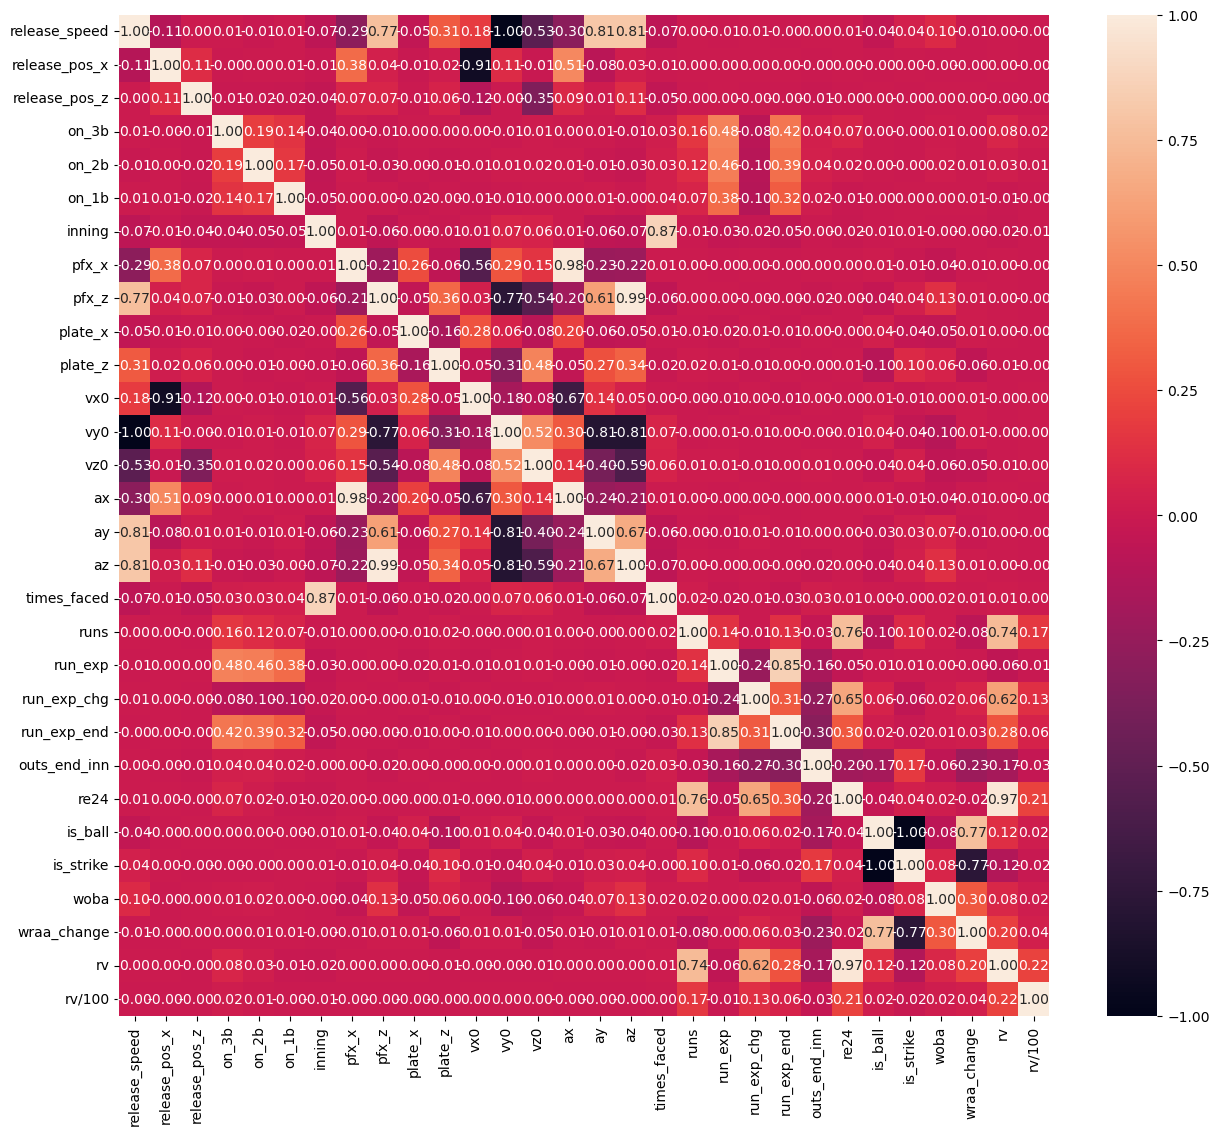

In [23]:
cool = sp[['release_speed',
 'release_pos_x',
 'release_pos_z','on_3b',
 'on_2b',
 'on_1b',
 'inning','pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z','vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az','times_faced',
 'runs',
 'run_exp',
 'run_exp_chg',
 'run_exp_end',
 'outs_end_inn',
 're24',
 'is_ball',
 'is_strike',
 'woba',
 'wraa_change',
 'rv',
 'rv/100']]
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(cool.corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = sp[['pitch_type', 'is_ball', 'is_strike']]
y = sp['rv']
y_binary = y.apply(lambda x: 1 if x < 0 else 0)

X_enc = pd.get_dummies(X, columns=['pitch_type'], drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_binary, test_size=0.25, random_state=40)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.88      0.76      0.82    126093
           1       0.85      0.93      0.89    180915

    accuracy                           0.86    307008
   macro avg       0.86      0.85      0.85    307008
weighted avg       0.86      0.86      0.86    307008



In [158]:
results_df = pd.DataFrame({'Actual_Label': y_test, 'Predicted_Label': y_pred})

# Add the feature columns from the test set (adjust as needed)
results_df = pd.concat([results_df, X_test], axis=1)

results_df

,Actual_Label,Predicted_Label,is_ball,is_strike,pitch_type_CS,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV
566200,0,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
597964,1,0,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
121142,1,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1047667,1,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
393204,1,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660413,1,1,0,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1185017,1,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
788513,1,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
842948,0,0,1,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [81]:
# data[(data['game_year'] == 2023) & (data['role_key'] == 'RP')].groupby(['player_name', 'game_year']).agg({'rv' : 'sum', 'rv/100' : 'sum'}).sort_values(by='rv')


In [29]:
elite_relievers = fangraphs[fangraphs['Role'] =='RP']
elite_relievers = elite_relievers[elite_relievers['SD'] >= 30]
elite_reliever_names = elite_relievers[["NameASCII","Season"]]

elite_relievers = fangraphs[fangraphs['Role'] =='RP']
elite_relievers = elite_relievers[elite_relievers['SD'] >= 30]
elite_reliever_names = elite_relievers[["NameASCII","Season"]]
elite_reliever_names["NameASCII"].str.lower()
elite_reliever_names = elite_reliever_names.rename({'NameASCII':'Name'},axis=1)
elite_reliever_names = elite_reliever_names["Name"].str.split().str[1]
elite_reliever_savant = savant
elite_reliever_savant["player_name"].str.lower()
elite_reliever_savant = elite_reliever_savant.rename({'player_name':'Name'},axis=1)
elite_reliever_savant["Name"] = elite_reliever_savant['Name'].str.split(',').str[0]


elite_rp_savant = elite_reliever_savant[elite_reliever_savant['Name'].isin(elite_reliever_names)]

In [30]:
elite_rp_savant

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,Name,batter,pitcher,events,description,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced
90,SI,2021-04-05,87.700,-1.980,5.220,Williams,541645,592866,single,hit_into_play,...,Standard,192.000,-0.048,0.716,SP,1,0,85,22,3
93,CU,2021-04-05,80.000,-1.980,5.260,Williams,541645,592866,NaN,blocked_ball,...,Standard,101.000,0.000,0.041,SP,1,0,84,22,3
119,SI,2021-04-05,87.300,-2.010,5.250,Williams,541645,592866,NaN,called_strike,...,Standard,199.000,0.000,-0.057,SP,1,0,83,22,3
123,FF,2021-04-05,88.400,-1.960,5.460,Williams,592885,592866,walk,ball,...,Standard,194.000,-0.026,0.171,SP,1,0,82,21,3
146,CH,2021-04-05,83.200,-1.920,5.410,Williams,592885,592866,NaN,ball,...,Standard,226.000,0.000,0.127,SP,1,0,81,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136298,FC,2023-05-26,88.100,-2.860,5.510,Ottavino,676701,493603,single,hit_into_play,...,Standard,154.000,-0.058,0.942,RP,0,1,1,1,1
2136299,ST,2023-05-26,78.400,-1.750,5.510,Adam,518692,592094,NaN,called_strike,...,Standard,55.000,0.000,-0.063,RP,0,1,1,1,1
2136308,SI,2023-05-26,94.700,2.770,5.720,Hader,664056,623352,NaN,called_strike,...,Standard,150.000,0.000,-0.038,RP,0,1,1,1,1
2136325,FC,2023-05-26,99.900,-0.930,5.970,Clase,676475,661403,NaN,swinging_strike,...,Standard,169.000,0.000,-0.038,RP,0,1,1,1,1


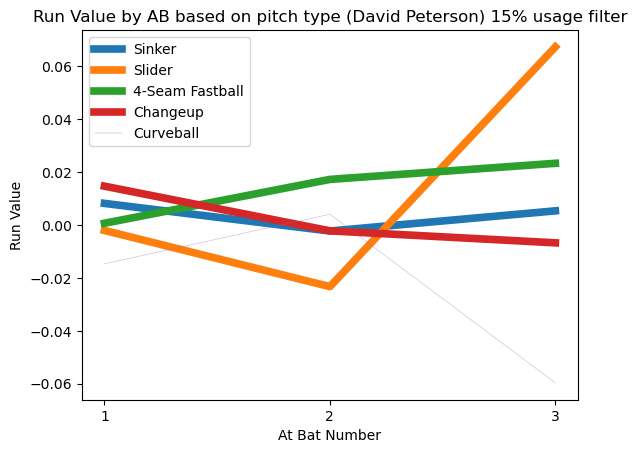

In [130]:
cool = sp[(sp['player_name'] == 'Peterson, David') & (sp['times_faced'] < 4) & (sp['game_year'] == 2023)]
pitch_types = cool['pitch_name'].unique()
colors = plt.cm.tab10(np.arange(len(pitch_types)))
total_pitches = cool['pitch_name'].count()
for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('times_faced')['rv'].mean()
    
    pitch_usage = subset['pitch_name'].count() / total_pitches
    
    if pitch_usage >= .15:
        width = 5.5
    else:
        width = 0.2 
        
        
    plt.plot(s.index, s, label=pitch_type, color=color, linewidth = width)

plt.title('Run Value by AB based on pitch type (David Peterson) 15% usage filter')
plt.xlabel('At Bat Number')
plt.ylabel('Run Value')
plt.xticks(range(1,4))
plt.legend()
plt.show()

In [107]:
total_pitches

1227433

In [45]:
sp[(sp['player_name'] == 'Gonsolin, Tony') & (sp['times_faced'] < 5) & (sp['game_year'] == 2023)].pitch_name.unique()


array(['4-Seam Fastball', 'Slider', 'Split-Finger', 'Curveball'],
      dtype=object)

In [140]:
filtered = fangraphs[(fangraphs['Role'] == 'SP') & (fangraphs['Season'] == 2023) & (fangraphs['FIP_minus'] >= 95) & ((fangraphs['Stuff_plus'] >= 90) & (fangraphs['Stuff_plus'] <= 100)) & (fangraphs['Age'] >= 26) & (fangraphs['Age'] < 31) & (fangraphs['IP'] <= 100)]


filtered[['Name', 'MLBAMID']]


,Name,MLBAMID
2786,JosÃ© Ruiz,614179
2794,Chad Kuhl,641771
2795,GermÃ¡n MÃ¡rquez,608566
2804,Brad Keller,641745
2809,Spencer Turnbull,605513
2814,Touki Toussaint,657053
2837,Jaime Barria,642545
2850,Dakota Hudson,641712
2852,Thomas Hatch,641672
2855,Cal Quantrill,615698


In [129]:
filtered = fangraphs[(fangraphs['Role'] == 'SP') & (fangraphs['GS'] >= 20) & (fangraphs['Season'] == 2023) & (fangraphs['xFIP_minus'] >= 100) & (fangraphs['K_pct_plus'] > 100)]


filtered[['Name', 'MLBAMID']]

,Name,MLBAMID
2726,Lance Lynn,458681
2782,Michael Wacha,608379
2800,Lucas Giolito,608337
2821,Jack Flaherty,656427
2877,Tyler Wells,669330
2887,Kutter Crawford,676710
3243,Andrew Heaney,571760
3322,Andrew Abbott,671096


In [145]:
pitchers_to_compare = ['Kopech, Michael', 'Peterson, David', 'Williams, Trevor']

selected_metrics = [
    'release_speed', 'release_spin_rate', 'effective_speed',
    'launch_speed', 'launch_angle', 'hit_distance_sc',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'
]

relievers = savant[savant['role_key'] == 'RP']



KeyError: 'player_name'

In [151]:
player_to_compare = 'Kopech, Michael'

# List of selected metrics
selected_metrics = [
    'release_speed', 'release_spin_rate', 'effective_speed',
    'launch_speed', 'launch_angle', 'hit_distance_sc',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'
]

# Filter data for Michael Kopech and selected metrics
kopech_data = savant[savant['player_name'] == player_to_compare][selected_metrics]

# Filter data for relievers
relievers = savant[(savant['role_key'] == 'RP') & (savant['player_name'] != player_to_compare)][selected_metrics]

# Handle missing values by filling NaNs with the mean for numeric columns
numeric_columns = relievers.select_dtypes(include=[np.number]).columns
relievers[numeric_columns] = relievers[numeric_columns].fillna(relievers[numeric_columns].mean())

# Function to calculate Euclidean distance between Kopech and each reliever
def calculate_distance(row):
    return euclidean(row.values, kopech_data.mean(axis=0).values)

# Calculate distance for each reliever
relievers['distance_to_kopech'] = relievers.apply(calculate_distance, axis=1)

# Sort relievers by distance (lower distance means more similarity)
similar_relievers = relievers.sort_values(by='distance_to_kopech').head(10)


In [163]:
result_df = pd.merge(savant, similar_relievers, on=['release_speed', 'release_spin_rate', 'effective_speed',
    'launch_speed', 'launch_angle', 'hit_distance_sc',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], how='left')

# Display the result with additional information
#print(result_df[['player_name', 'distance_to_kopech', 'release_speed', 'release_spin_rate', 'effective_speed']])



In [165]:
result_df[result_df['distance_to_kopech'] > 0]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,spin_axis,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,distance_to_kopech
987294,SL,2022-06-20,91.000,-1.280,5.660,"Graveman, Kendall",606192,608665,double,hit_into_play,...,185.000,-0.033,0.442,RP,0,1,11,2,1,11.252
